In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Helper Functions

In [2]:
def load_spectrum(fname):
    '''
    Read spectrum from CSV
    '''
    
    with open(fname ,"r") as f:
        for x, line in enumerate(f):
            if(line == 'Channel Data:\n'):
                data_start = x+2
                break

    try:
        data = np.loadtxt(fname, unpack=True, skiprows=data_start, delimiter= ",", usecols=[0, 1, 2])
    except:
        data = np.loadtxt(fname, unpack=True, skiprows=data_start, delimiter= ",", usecols=[0, 2])

    channel = data[0]
    counts = data[-1]
    dcounts = np.sqrt(counts)
    for i, value in enumerate(dcounts):
        if value == 0: dcounts[i] = 1.14
    
    energy = data[1] if data.shape[0] > 2 else None
    
    return channel, energy, counts, dcounts

In [3]:
def gaussianfunc(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))

def linearfunc(p,x):
    return p[0]*x + p[1]

def gaussianlinear(p,x):
    return gaussianfunc(p[0:3],x) + linearfunc(p[3:5],x)

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

In [4]:
# The code below defines our data fitting function.
# Inputs are:
# initial guess for parameters p0
# the function we're fitting to
# the x,y, and dy variables
# tmi can be set to 1 or 2 if more intermediate data is needed

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), np.nan, np.nan
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), np.nan, np.nan
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

# Spectra

In [8]:
spectrum_fname = './data/scattering_spectra/30-1.csv'

Text(0.5, 1.0, 'Scattering of Cesium-137 Gammas at 30 degrees')

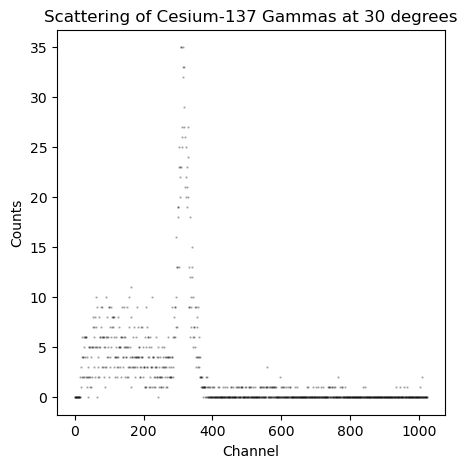

In [11]:
import matplotlib.patches as mpatches

channel, _, counts, dcounts = load_spectrum(spectrum_fname)

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(channel, counts, marker='.', color='black', s=2, alpha=0.25, label='Data')

ax.set_xlabel('Channel')
ax.set_ylabel('Counts')
ax.set_title('Scattering of Cesium-137 Gammas at 30 degrees')

In [12]:
fig.savefig('./figures/scattering1-30.pdf')

# Fitting Region

In [249]:
fit_regions = [(260, 350)]

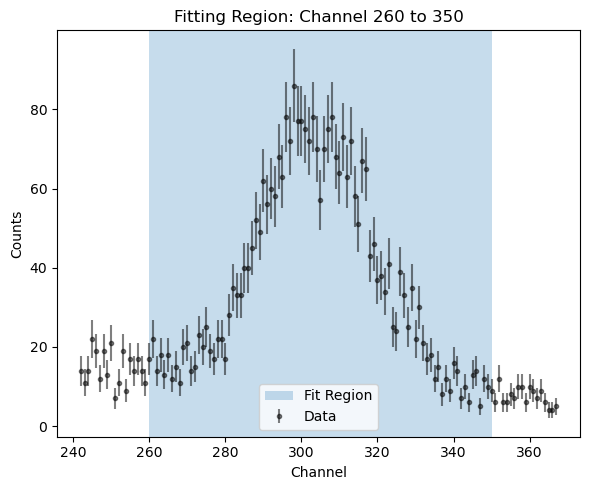

In [250]:
fig, axs = plt.subplots(1, len(fit_regions), figsize=(6 * len(fit_regions), 5))
if len(fit_regions) == 1: axs = [axs]

for ax, (min_x, max_x) in zip(axs, fit_regions):

    padding = (max_x - min_x) // 5
    padded_min_x = max(0, min_x - padding)
    padded_max_x = min(channel.shape[0], max_x + padding)
    
    ax.errorbar(
        channel[padded_min_x: padded_max_x], 
        counts[padded_min_x: padded_max_x], 
        dcounts[padded_min_x: padded_max_x], 
        fmt='k.', alpha=0.5, label='Data'
    )

    parameters_i = [
        10000, 
        (min_x + max_x) // 2, 
        max_x - min_x, 
        0, 0
    ]

    ax.axvspan(channel[min_x], channel[max_x], label='Fit Region', alpha=0.25)

    ax.set_xlabel('Channel')
    ax.set_ylabel('Counts')
    ax.set_title(f'Fitting Region: Channel {min_x} to {max_x}')
    ax.legend()

plt.tight_layout()

# Fitted Peak

In [251]:
title = 'Cesium-137 Scattering at 120 degrees'

[86.0, 305.0, 22.0, 0.1, 5.0]

Converged with chi-squared 84.70
Number of degrees of freedom, dof = 85.00
Reduced chi-squared 1.00

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 8.600e+01                | -2.279e+03               | 9.189e+01               
1           | 3.050e+02                | 3.040e+02                | 4.476e-01               
2           | 2.200e+01                | -1.389e+01               | 4.933e-01               
3           | 1.000e-01                | -6.444e-02               | 1.855e-02               
4           | 5.000e+00                | 3.044e+01                | 5.971e+00               


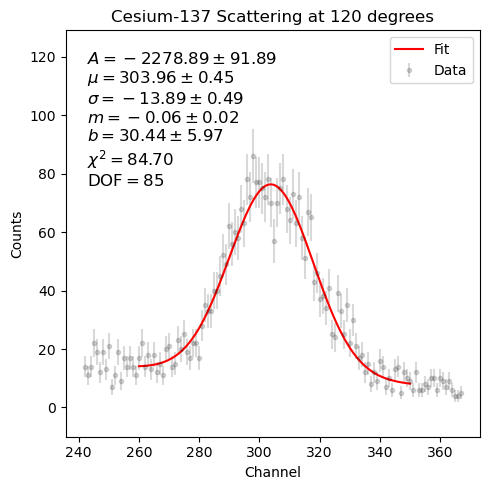

In [252]:
fig, axs = plt.subplots(1, len(fit_regions), figsize=(5 * len(fit_regions), 5))
if len(fit_regions) == 1: axs = [axs]

for ax, (min_x, max_x) in zip(axs, fit_regions):

    padding = (max_x - min_x) // 5
    padded_min_x = max(0, min_x - padding)
    padded_max_x = min(channel.shape[0], max_x + padding)
    
    ax.errorbar(
        channel[padded_min_x: padded_max_x], 
        counts[padded_min_x: padded_max_x], 
        dcounts[padded_min_x: padded_max_x], 
        fmt='k.', alpha=0.15, label='Data'
    )

    params_i = [
        counts[min_x : max_x].max(), 
        (channel[min_x] + channel[max_x]) // 2, 
        (channel[max_x] - channel[min_x]) // 4, 
        0.1, 
        counts[min_x : max_x].min() 
    ]

    print(params_i)

    params_f, params_err, chisq, dof = data_fit(
        params_i, 
        gaussianlinear, 
        channel[min_x : max_x], 
        counts[min_x : max_x], 
        dcounts[min_x : max_x]
    )

    linspace = np.linspace(channel[min_x], channel[max_x], 1000)

    ax.plot(linspace, gaussianlinear(params_f, linspace), label='Fit', color='r')

    txt = ''
    #txt = 'Range of Data: [{:.1f}, {:.1f}] KeV \n'.format(channel[min_x], channel[max_x])
    #txt += 'Fit Functional Form: $\\frac{A}{\\sigma \\sqrt{2 \\pi}} \\: \\exp[- \\frac{(x - \\mu)^2}{2 \\sigma^2}] + mx + b$ \n'
    txt += '$A = {:.2f} \\pm {:.2f}$ \n'.format(params_f[0], params_err[0])
    txt += '$\\mu = {:.2f} \\pm {:.2f}$ \n'.format(params_f[1], params_err[1])
    txt += '$\\sigma = {:.2f} \\pm {:.2f}$ \n'.format(params_f[2], params_err[2])
    txt += '$m = {:.2f} \\pm {:.2f}$ \n'.format(params_f[3], params_err[3])
    txt += '$b = {:.2f} \\pm {:.2f}$ \n'.format(params_f[4], params_err[4])
    txt += '$\\chi^2 = {:.2f}$ \n'.format(chisq)
    txt += 'DOF$ = {}$'.format(dof)
    ax.text(0.05, 0.95, txt, transform=ax.transAxes , fontsize=12, verticalalignment='top')

    ax.set_ylim([-10, counts.max() * 1.5])
    ax.set_xlabel('Channel')
    ax.set_ylabel('Counts')
    ax.set_title(title)
    ax.legend()

plt.tight_layout()

In [253]:
#fig.savefig('./figures/scattering3/120.pdf')